<a href="https://colab.research.google.com/github/ramarh1/Netflix_Recommender/blob/main/FinalProj_DSCI632_Huntley.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project DSCI632
Name: Ramar Huntley

Email: rh877@drexel.edu

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

!wget -q https://downloads.apache.org/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz

!tar xf spark-3.5.1-bin-hadoop3.tgz

!pip install -q findspark

import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"

import findspark

findspark.init()

In [ ]:
from pyspark.sql import SparkSession
APP_NAME = "Netflix Recommender System"
SPARK_URL = "/usr/local[*]"
spark = SparkSession.builder.appName(APP_NAME).getOrCreate()

## Background

1. Why are you choosing this dataset?
The dataset presented is a Netflix database taken from Kaggle, presenting the description, title, genre, certificate, year, cast, and ratings from IMDB. I chose this dataset because it seemed perfect for building a recommender system using cosine similarity.
Reference: https://www.kaggle.com/datasets/narayan63/netflix-popular-movies-dataset?resource=download


2. What variables will you use?
The variables that I will be more focused on are **title**, **duration**, **rating**, and **description**, which are the most important variables required to recommend shows.


3. What analysis(es) will you run?
I will compare movie/show descriptions using cosine similarity to recommend shows to Netflix users.


4. Do you have any hypotheses? What are they?
My hypothesis is that the votes variable (how many votes received by a Netflix title) will have a positive correlation with the overall rating a title receives.


In [ ]:
import pandas as pd

In [ ]:
# Loading the data

from pyspark.sql.types import StructType, StructField, FloatType, StringType, IntegerType, DoubleType

#Change schema of duration and votes row
netflixSchema = StructType([
  StructField('title', StringType(), True),
  StructField('year', StringType(), True),
  StructField('certificate', StringType(), True),
  StructField('duration', StringType(), True),
  StructField('genre', StringType(), True),
  StructField('rating', DoubleType(), True),
  StructField('description', StringType(), True),
  StructField('stars', StringType(), True),
  StructField('votes', StringType(), True)

])

location = "/content/n_movies.csv"

netflix_df = spark.read.format('csv').option('header', 'true').schema(netflixSchema).load(location)

In [ ]:
netflix_df.show(truncate=True)

+--------------------+-----------+-----------+--------+--------------------+------+--------------------+--------------------+---------+
|               title|       year|certificate|duration|               genre|rating|         description|               stars|    votes|
+--------------------+-----------+-----------+--------+--------------------+------+--------------------+--------------------+---------+
|           Cobra Kai|   (2018– )|      TV-14|  30 min|Action, Comedy, D...|   8.5|Decades after the...|['Ralph Macchio, ...|  177,031|
|           The Crown|   (2016– )|      TV-MA|  58 min|Biography, Drama,...|   8.7|Follows the polit...|['Claire Foy, ', ...|  199,885|
|    Better Call Saul|(2015–2022)|      TV-MA|  46 min|        Crime, Drama|   8.9|The trials and tr...|['Bob Odenkirk, '...|  501,384|
|       Devil in Ohio|     (2022)|      TV-MA| 356 min|Drama, Horror, My...|   5.9|When a psychiatri...|['Emily Deschanel...|    9,773|
|Cyberpunk: Edgeru...|   (2022– )|      TV-MA|  

In [ ]:
netflix_df.printSchema()

root
 |-- title: string (nullable = true)
 |-- year: string (nullable = true)
 |-- certificate: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- description: string (nullable = true)
 |-- stars: string (nullable = true)
 |-- votes: string (nullable = true)



# Section 2: Clean the data

10 points

Not every dataset is going to be ready to use right away. Take steps to fix incorrect inputs, remove null values, and assign datatypes that fit each feature.

### This section should include one or more of the following:
- A count of rows before and after dropping data with null or incorrect values, including an explaination of why removing the rows was necessary in [markdown](https://www.markdownguide.org/cheat-sheet).
- Renaming a column, adding a new one, or casting an existing one as a different datatype.
- Remove punctuation marks, symbols, etc from the data, and convert all upper-case lettering to lower-case.
- Remove or fix rows that have bad values/data.

In [ ]:
# Count of rows before cleaning dataset
netflix_df.count()

9957

In [ ]:
netflix_df.printSchema()

root
 |-- title: string (nullable = true)
 |-- year: string (nullable = true)
 |-- certificate: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- description: string (nullable = true)
 |-- stars: string (nullable = true)
 |-- votes: string (nullable = true)



In [ ]:
# Removing commas in votes column, and removing min in duration column
from pyspark.sql.functions import regexp_replace
netflix_df = netflix_df.withColumn('votes', regexp_replace('votes', ',', ''))
netflix_df = netflix_df.withColumn('duration', regexp_replace('duration', 'min', ''))

#Cast votes and duration col to integer
netflix_df = netflix_df.withColumn("votes", netflix_df.votes.cast(IntegerType()))
netflix_df = netflix_df.withColumn("duration", netflix_df.duration.cast(IntegerType()))

In [ ]:
from pyspark.sql.functions import lower, split, col

netflix_df = netflix_df.withColumn("title", lower(netflix_df["title"]))
netflix_df = netflix_df.withColumn("description", lower(netflix_df["description"]))
netflix_df = netflix_df.withColumn("genre", lower(netflix_df["genre"]))

In the next step, we removed stars, certificate, and year, since these variables will not help us predict how popular a show or movie is.

In [ ]:
# Dropping unnecessary columns (stars, certificate, year)
netflix_df = netflix_df.drop("stars", "certificate", "year")

In [ ]:
 #dropping duplicates
netflix_df = netflix_df.dropDuplicates(["title"])

In [ ]:
 #dropping nulls
netflix_df = netflix_df.na.drop(subset=["duration", "rating"])

In [ ]:
netflix_df.show(truncate=False)

+------------------------------------------------+--------+--------------------------+------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|title                                           |duration|genre                     |rating|description                                                                                                                                                                                                                                          |votes|
+------------------------------------------------+--------+--------------------------+------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Display row count of Netflix dataframe after cleaning and transforming data.

In [ ]:
netflix_df.count()

6239

In [ ]:
# used to transform rdd and filter column for unwanted spaces
netflixdf2=netflix_df.select("description")
rddnetflix=netflixdf2.rdd.flatMap(lambda x:x)
rddnetflix = rddnetflix.flatMap(lambda x: x.split(" "))
rddnetflix = rddnetflix.filter(lambda x: x!="" and x!="..." and x!="summary\xa0»")
netflixcount = rddnetflix.map(lambda word: (word, 1))
netflixcountrbk = netflixcount.reduceByKey(lambda x,y: (x+y)).sortByKey()
netflixcountrbk = netflixcountrbk.map(lambda x: (x[1], x[0]))

In [ ]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
stopwords = stopwords.words("english")
netflixcountrbk = netflixcountrbk.filter(lambda x: x[1] not in stopwords).sortByKey(False)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Top 10 most common words used in Netflix descriptions, including count and word

In [ ]:
netflixcountrbk.take(10)

[(620, 'see'),
 (613, 'full'),
 (490, 'new'),
 (489, 'young'),
 (468, 'life'),
 (401, 'one'),
 (392, 'two'),
 (369, 'story'),
 (339, 'world'),
 (324, 'family')]

Creating SQL temp view so we can find out top 10 titles and bottom 10 titles

In [ ]:
# Register table so we can run spark SQL queries
netflix_df.createOrReplaceTempView("netflix")

In [ ]:
# Convert pyspark df to pandas df for tfid vectorizer
netflix_df_pd = netflix_df.toPandas()

In [ ]:
# SQL query to show the top shows basd on rating
top_10_movies = spark.sql("SELECT * FROM netflix ORDER BY rating DESC LIMIT 10")
top_10_movies.show(truncate=False)

+-------------------------------+--------+----------------------------+------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+
|title                          |duration|genre                       |rating|description                                                                                                                                                                                                                      |votes  |
+-------------------------------+--------+----------------------------+------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+
|1899                           |60      |drama, history, hor

In [ ]:
# SQL query to show the least liked shows basd on rating
bttm_10_movies = spark.sql("SELECT * FROM netflix ORDER BY rating ASC LIMIT 10")
bttm_10_movies.show(truncate=False)

+--------------------------------+--------+---------------------------+------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|title                           |duration|genre                      |rating|description                                                                                                                                                                                                                      |votes|
+--------------------------------+--------+---------------------------+------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|defcon 2012                     |92      |sci-fi                  

In [ ]:
top_10_movies_pd = top_10_movies.toPandas()

In [ ]:
top_10_movies_pd.head(10)

,title,duration,genre,rating,description,votes
0,1899,60,"drama, history, horror",9.6,multinational immigrants traveling from the ol...,853
1,breaking bad,49,"crime, drama, thriller",9.5,a high school chemistry teacher diagnosed with...,1831340
2,elesin oba: the king's horseman,96,"adventure, drama, history",9.4,"inspired by true life events, in the oyo empir...",72
3,avatar: the last airbender,23,"animation, action, adventure",9.3,"in a war-torn world of elemental magic, a youn...",309241
4,cosmos: a spacetime odyssey,557,documentary,9.3,an exploration of our discovery of the laws of...,121400
5,our planet,403,documentary,9.3,documentary series focusing on the breadth of ...,43175
6,reply 1988,90,"comedy, drama, family",9.2,follows the lives of 5 families living on the ...,7286
7,rick and morty,23,"animation, adventure, comedy",9.2,an animated series that follows the exploits o...,502160
8,my mister,70,"drama, family",9.1,a man in his 40's withstands the weight of lif...,6442
9,leyla and mecnun,80,"adventure, comedy, drama",9.1,turkish television comedy series set in istanb...,93632


In [ ]:
bttm_10_movies_pd = bttm_10_movies.toPandas()
bttm_10_movies_pd.head()

,title,duration,genre,rating,description,votes
0,defcon 2012,92,sci-fi,1.7,"on october 30, 2009 an independent filmmaker a...",407
1,hajwala: the missing engine,96,"action, adventure, crime",2.0,khalid and kehailan are two team leaders who a...,261
2,way of the vampire,82,"action, horror, thriller",2.0,"after defeating dracula, van helsing is grante...",1649
3,the hype house,36,reality-tv,2.1,get an inside look at social media's least tal...,2955
4,thomas & friends: all engines go,30,"animation, short, adventure",2.1,"all aboard, everyone. it's all engines go as t...",604


array([[<Axes: title={'center': 'rating'}>]], dtype=object)

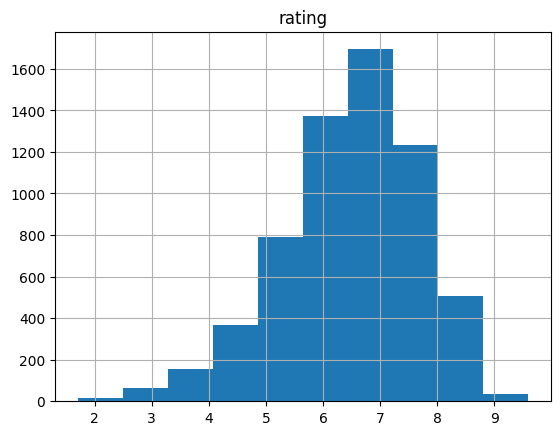

In [ ]:
netflix_df_pd.hist('rating')

From this histogram, we can see that the rating variable has a slightly left skewed distribution.

array([[<Axes: title={'center': 'duration'}>]], dtype=object)

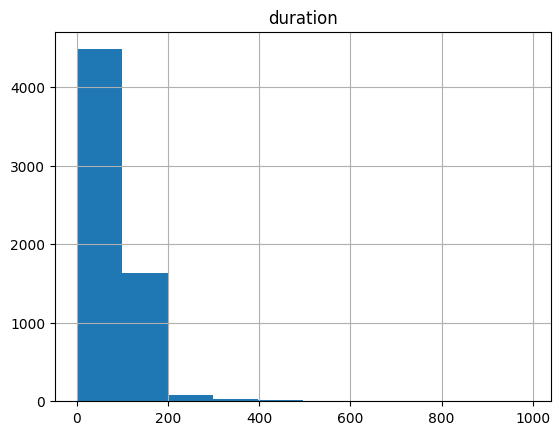

In [ ]:
netflix_df_pd.hist('duration')

For the duration variable histogram, we can observe that most of the catalog falls between 0 and 200 minutes.

In [ ]:
# create visualization with most popular titles according to ratings
import plotly.express as px

fig = px.bar(x=top_10_movies_pd.title, y=top_10_movies_pd.rating, color=top_10_movies_pd.rating, title= 'Top 10 Netflix Titles Based on Rating', labels={'x':'Film Title', 'y': 'Rating'}, height=400)
fig.show()

In [ ]:
# create visualization with titles with the longest duration
import plotly.express as px

fig = px.bar(x=top_10_movies_pd.title, y=top_10_movies_pd.duration, color=top_10_movies_pd.duration, title= 'Duration of Top 10 Titles', labels={'x':'Netflix Title', 'y': 'Duration (mins)'}, height=400)
fig.show()

In [ ]:
# create visualization with least popular titles according to ratings
import plotly.express as px

fig = px.bar(x=bttm_10_movies_pd.title, y=bttm_10_movies_pd.rating, color=bttm_10_movies_pd.rating, title= 'Bottom 10 Netflix Titles Based on Rating', labels={'x':'Film Title', 'y': 'Rating'}, height=400)
fig.show()

# Section 3: Transform the clean data

10 points

Once you have clean data, start to prepare it to fit your analysis tools. This might mean using custom code to normalize certain values, joining supplemental datasets, and/or preparing it for machine learning.

### This section should include one or more of the following:
- Write a UDF to perform a function, then use it to add a new column to your data. Explain why in [markdown](https://www.markdownguide.org/cheat-sheet)
- Join an outside data source. (It can be one you've prepared alongside the primary source you're using, as long as you link it)
- Split the data into train/test sets
- Create vectors for relavent features
- One-hot encode catagorical variables

In [ ]:
import pandas as pd
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType


indices = pd.Series(netflix_df_pd.index, index=netflix_df_pd['title'])

def get_recommendations(cosine_sim, indices):
  tries = 10
  for i in range(tries):

      if(tries == 5):
        print("You have made the max amount of attempts.")
        break
      try:
        # Ask user for input
        title = input("Please enter a movie title to receive recommendations: ")

        # Get the index of the movie that matches the title
        idx = indices[title]
        # Get the pairwsie similarity scores
        sim_scores = list(enumerate(cosine_sim[idx]))
        # Sort the movies based on the similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        # Get the scores for 10 most similar movies
        sim_scores = sim_scores[1:11]
        # Get the movie indices
        movie_indices = [i[0] for i in sim_scores]
        # Return the top 10 most similar movies
        print("----Here are your recommended Netflix titles---- \n")
        return netflix_df_pd['title'].iloc[movie_indices]

      except:
        print("Not found. Please enter a different title.")
        continue

      break

In [ ]:
movie_plots = netflix_df_pd['description']

# Section 4: Show your analysis of the data

10 points

This is where the science happens. Use your data to show some kind of insight, and how you got there. Make the reader understand why it's important, and how they can get the same conslusion, and/or what would need to change to reach a different one.

### This section should include one or more of the following:
- Fit the data to a model
- Show the outcome of clustering, regression, and/or classification algorithms.
 - We used several in class, but you can use whatever fits your needs for this assignment
- Reccomend a product/item
- Use a SQL query to filter results

Below, we can see the average duration, rating, and votes of the Netflix catalog in the database. From this analysis, we can assume that the shows have slightly below moderate rating/popularity.

In [ ]:
df_numeric = netflix_df.select('duration','rating','votes')
df_numeric.describe().show()

The first value that the pearson correlation function outputs is the r value of two variables. Thus, will be analyzing the relationship between the amount of votes a Netflix receives and the rating. Since it has an r-value of 0.21, this means that the two variables have a poor positive correlation. They do not have a linear relationship.

In [36]:
from scipy.stats import pearsonr

#calculation correlation coefficient and p-value between votes and rating
pearsonr(netflix_df_pd['votes'], netflix_df_pd['rating'])


ValueError: array must not contain infs or NaNs

A TF-IDF matrix will be constructed to compare the similarity of Netflix title descriptions, which will be used to recommend titles with similar plots to interested Netflix users.

In [37]:
tfidf = TfidfVectorizer(stop_words='english')

# Construct the TF-IDF matrix by fitting and transforming data to create a matrix
tfidf_matrix = tfidf.fit_transform(movie_plots)

# Generate the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

The final step involves getting user input in order to suggest a similar movie or show based on description.

In [39]:
#Generate Recommendations based on similar description/plots
print(get_recommendations(cosine_sim, indices))

Please enter a movie title to receive recommendations: our planet
----Here are your recommended Netflix titles---- 

5188            the lazarus papers
4320                         shark
3151                 meerkat manor
4729                        temple
1816                 frozen planet
6093    win the wilderness: alaska
3182         message from the king
3143                     meateater
1413                          dogs
5277             the negro soldier
Name: title, dtype: object
